## Whale Sound Mining

In this tutorial we will explore some data which contain right whale calls. The dataset was shared as part of a [2013 Kaggle competition](https://www.kaggle.com/c/whale-detection-challenge). Our goal is not to show the best winning algorithm to detect a call, but share a simple pipeline for processing oscillatory data, which possibly can be used on wide range of time series.

Objectives:
* read and extract features form audio data
* apply dimensionality reduction techinques
* perform supervised classification
* learn how to evaluate machine learning models
* train a neural network to detect whale calls


### Data Loading and Exploration
---

In [1]:
# importing multiple visualization libraries
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import pylab as pl
import seaborn

/Users/valentina/anaconda/envs/data_mining_test/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# importing libraries to manipulate the data files
import os
from glob import glob

In [3]:
# import a library to read the .aiff format
import aifc

The `train` folder contains many `.aiff` files (2 second snippets) and we have `.csv` document which contains the corresponding labels. 

In [4]:
!ls whale_data

test      test.csv  train     train.csv


In [5]:
filenames = glob(os.path.join('whale_data','train','*.aiff'))

In [6]:
print('There are '+str(len(filenames))+' files.' )

There are 30000 files.


In [7]:
# read the labels
import pandas as pd
labels = pd.read_csv(os.path.join('whale_data','train.csv'), index_col = 0)

The format of the labels is

In [8]:
labels.head(10)

,label
clip_name,
train1.aiff,0
train2.aiff,0
train3.aiff,0
train4.aiff,0
train5.aiff,0
train6.aiff,1
train7.aiff,1
train8.aiff,0
train9.aiff,1


In [9]:
# filenames which contain calls
whale_labels = labels[labels['label'] == 1].index

In [102]:
# save a variable which only contains files with right whale calls
X_whales = X[whale_labels]
X_whales.shape

(3540, 7027)

In [11]:
whale_labels[0]

'train6.aiff'

In [12]:
print('There are '+str(len(whale_labels))+' calls.')

There are 7027 calls.


Let's look at one of those files.

In [13]:
# reading the file info
whale_sample_file = whale_labels[0] 
whale_sample_file = 'train5.aiff'
whale_aiff = aifc.open(os.path.join('whale_data','train',whale_sample_file),'r')
print ("Frames:", whale_aiff.getnframes() )
print ("Frame rate (frames per second):", whale_aiff.getframerate())

Frames: 4000
Frame rate (frames per second): 2000


/Users/valentina/anaconda/envs/data_mining_test/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until


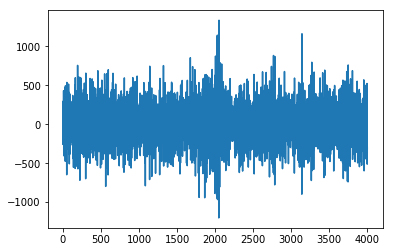

In [14]:
# reading the data
whale_strSig = whale_aiff.readframes(whale_aiff.getnframes())
whale_array = np.fromstring(whale_strSig, np.short).byteswap()
plt.plot(whale_array)

In [15]:
signal = whale_array.astype('float64')

In [16]:
# playing a whale upcall in the notebook
from IPython.display import Audio
Audio(signal, rate=3000, autoplay = True)# the rate is set to 3000 make the widget to run (seems the widget does not run with rate below 3000)

Working directly with the signals is hard (there is important frequency information). Let's calculate the spectrogram for each of the signals and use them as features.

In [17]:
# a function for plotting histograms
def PlotSpecgram(P, freqs, bins):
    """Spectrogram"""
    Z = np.flipud(P) # flip rows so that top goes to bottom, bottom to top, etc.
    xextent = 0, np.amax(bins)
    xmin, xmax = xextent
    extent = xmin, xmax, freqs[0], freqs[-1]

    im = pl.imshow(Z, extent=extent,cmap = 'plasma')
    pl.axis('auto')
    pl.xlim([0.0, bins[-1]])
    pl.ylim([0, freqs[-1]])

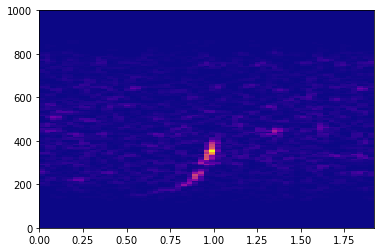

In [18]:
params = {'NFFT':256, 'Fs':2000, 'noverlap':192}
P, freqs, bins = mlab.specgram(whale_array, **params)
PlotSpecgram(P, freqs, bins)

In [19]:
P.shape

(129, 59)

In [20]:
# create a dictionary which contains all the spectrograms
spec_dict = {}

In [21]:
# cutting the higher frequencies ([:60,:])
m = 60
for filename in filenames[::1]:
    aiff = aifc.open(filename,'r')
    whale_strSig = aiff.readframes(aiff.getnframes())
    whale_array = np.fromstring(whale_strSig, np.short).byteswap()
    P, freqs, bins = mlab.specgram(whale_array, **params)
    spec_dict[filename] = P[:m,:]
    
    

/Users/valentina/anaconda/envs/data_mining_test/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


Most machine learning algorithms in Python expect the data to come in a format *features* x *samples*.

In [22]:
# The key below depends on the directory structure
feature_dict = {}
for key in filenames[::1]:
    feature_dict[key[17:]] = spec_dict[key].ravel()

In [23]:
X = pd.DataFrame(feature_dict)

In [24]:
del feature_dict
del spec_dict

In [25]:
# let's save these variables for reuse
np.save('X.npy',X)
np.save('Y.npy',np.array(labels['label'][X.columns]))

### Machine Learning Methods Overview
---

Choosing a Machine Learning Algorithm as of 2013.

[//]:![text](https://gist.githubusercontent.com/amueller/4642976/raw/e48eff2df7790583f1f3212095d24639738a1b4a/drop_shadows.svg?sanitize=true)

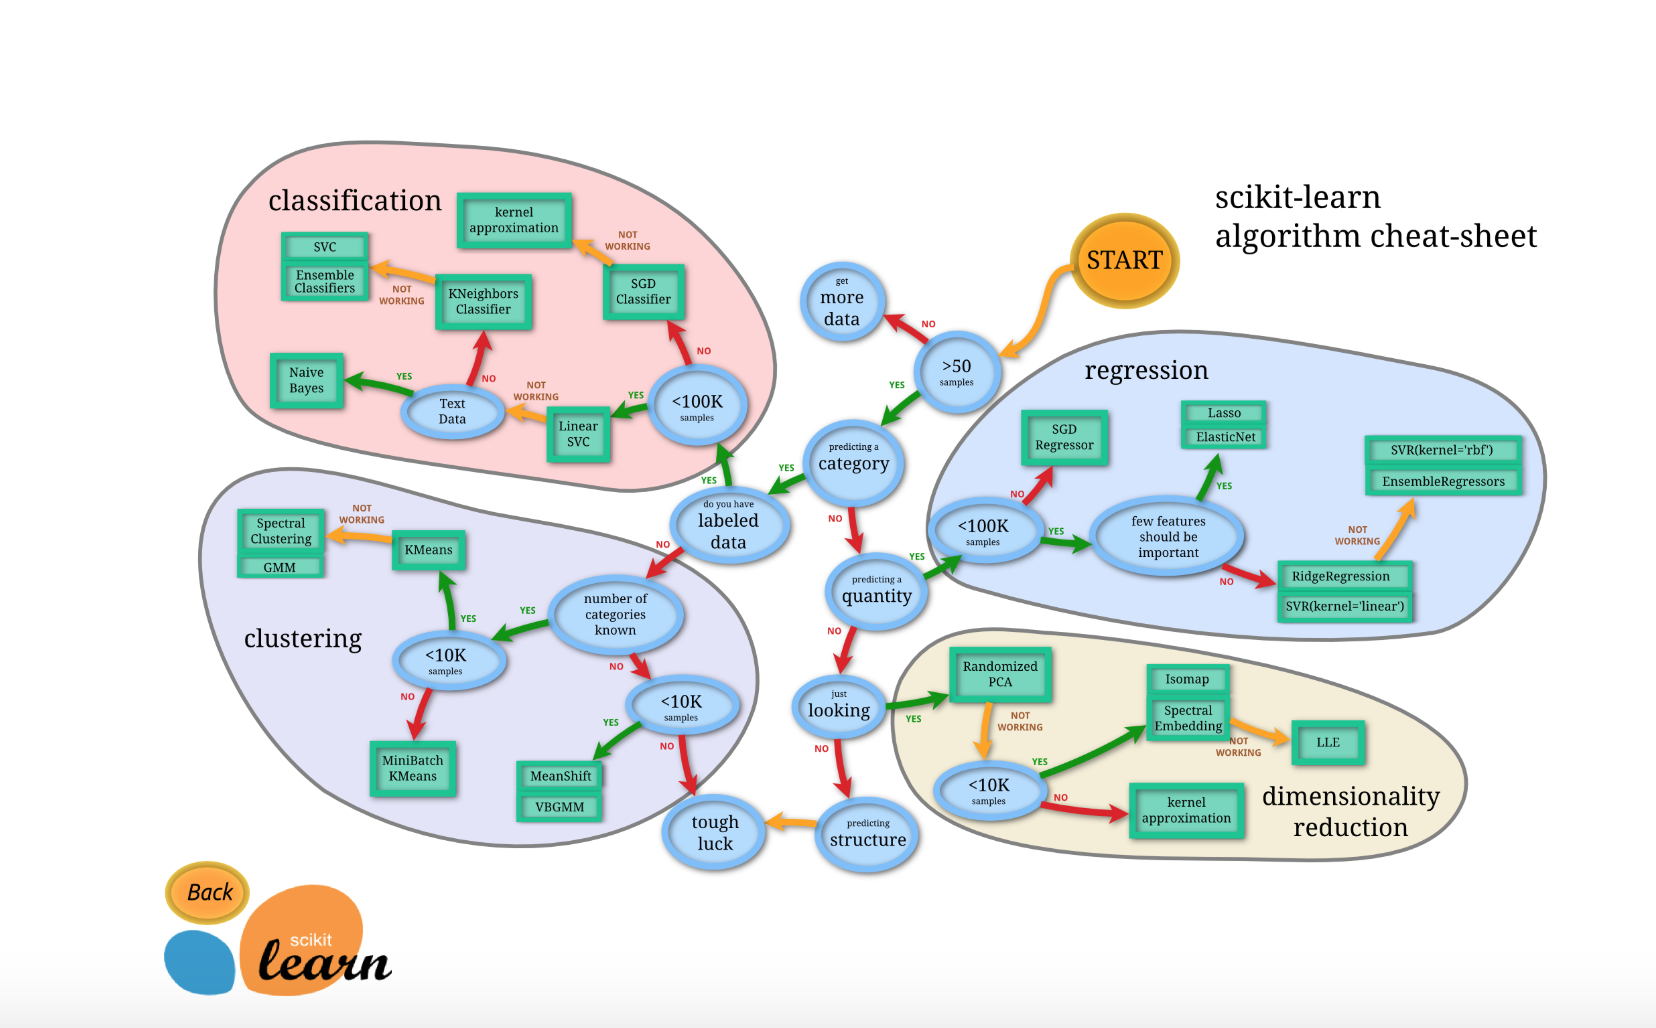

In [26]:
from  IPython.display import Image
Image("MLmap.png" )

Source: http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html 

#### Dimensionality Reduction

We can now represent each signal with its spectrogram, which can be treated as a high dimensional vector. However, we can try to look for common patterns in those spectrograms and attempt to represent them with fewer dimensions. This can be accomplished by linear dimenionsality techniques such as Principal Component Analysis (PCA) and Independent Component Analysis (ICA). These techniques are easy to apply with the Python's `scikit-learn` library.

#### PCA

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30,copy=True)
X_transformed = pca.fit_transform(np.log(X.T))

The resulting dimensions are:

In [ ]:
X_transformed.shape

Why did I pick 30 components?

Text(0.5,1,'Singular values')

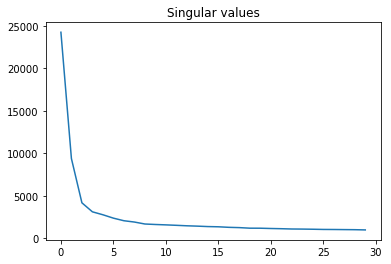

In [55]:
plt.plot(pca.singular_values_)
plt.title("Singular values")

In [58]:
pca.components_.shape

(30, 3540)

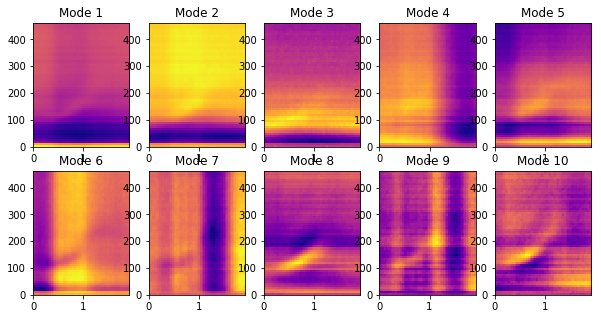

In [59]:
# plot first ten components
plt.figure(figsize = (10,5))
u = pca.components_[:,:].reshape(30,-1,59)
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow((np.squeeze(u[i,:,:])-u.min())/(u.max() - u.min()), vmin = 0, vmax = 1,cmap = 'plasma')
    PlotSpecgram(u[i,:,:],freqs[:m],bins)
    plt.title('Mode '+str(i+1))

In [60]:
# Exercise: try Nonnegative Matrix Factorization(NMF), Indpenent Component Analysis
from sklearn.decomposition import NMF
from sklearn.decomposition import FastICA
# nmf = NMF(n_components=30)
# X_transformed = nmf.fit_transform(X.iloc[:,:].T)

*Visualizing Components*

Let's try to visualize the components as points in 2D.

In [61]:
# create a list of colors
colors = []
for c in labels['label'][X.columns]:
    if c==1:
        colors.append('red')
    else:
        colors.append('cyan')

Text(0.5,1,'Projection of the data on 2 components - ground truth labels')

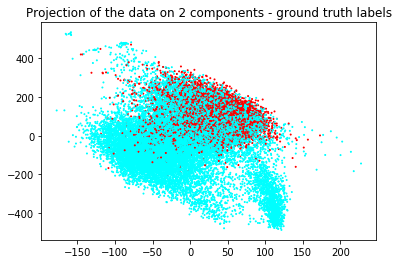

In [63]:
plt.scatter(X_transformed[:,1],X_transformed[:,0],[],color = colors)
#plt.xlim(-100000,100000)
#plt.ylim(-100000,100000)
plt.title("Projection of the data on 2 components - ground truth labels")

Few dimensions do not seem sufficient to separate the dataset.

In [68]:
spec_dim = 60,59

In [69]:
# The code below visualizes the data projected in 2D together with the original spectrograms

from matplotlib import offsetbox
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
# Scale and visualize the embedding vectors
def plot_embedding(X, X_embedded, title=None):
    x_min, x_max = np.min(X_embedded, 0), np.max(X_embedded, 0)
    X_embedded = (X_embedded - x_min) / (x_max - x_min)

    plt.figure(figsize = (10,10))
    ax = plt.subplot(111)
    for i in range(X_embedded.shape[0]):
        plt.text(X_embedded[i, 0], X_embedded[i, 1], 'o',
                 #color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X_embedded.shape[0]):
            dist = np.sum((X_embedded[i,:] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X_embedded[i,:]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(np.log(X[i,:].reshape(spec_dim)),zoom = 0.3, cmap='plasma'),
                X_embedded[i,:])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

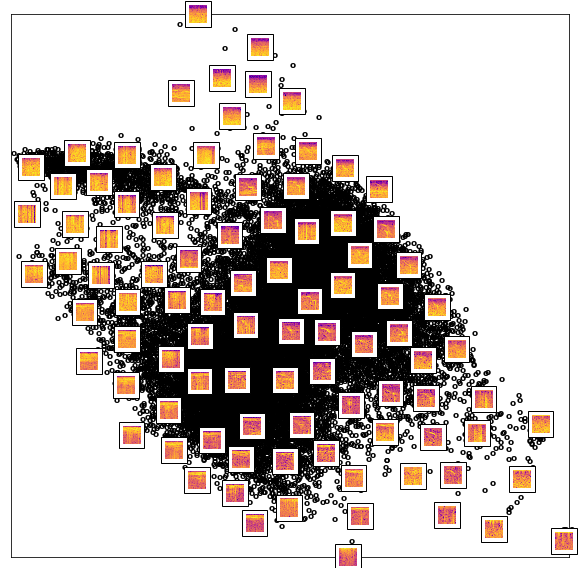

In [70]:
plot_embedding(np.array(X).T, X_transformed[:,:2])
plt.show()

*Nonlinear Dimensionality Reduction*

PCA is a linear dimensionality reductions technique. Sometimes a linear transformation is not good enought to separate the data well. Then one can resort to nonlinear dimensionality reductions techniques, which find an embedding of the data in a lower domensional space, which preserves some properties of the geometry of the data. [TSNE](https://lvdmaaten.github.io/tsne/) is one such technique and it can be used very similarly to PCA.



In [66]:
%%time
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


/Users/valentina/anaconda/envs/data_mining_test/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


(3540, 2)

Text(0.5,1,'Projection of the data on 2 components')

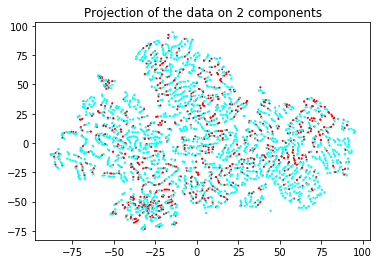

In [71]:
plt.scatter(X_embedded[:,1],X_embedded[:,0],[],color = colors)
plt.title("Projection of the data on 2 components")

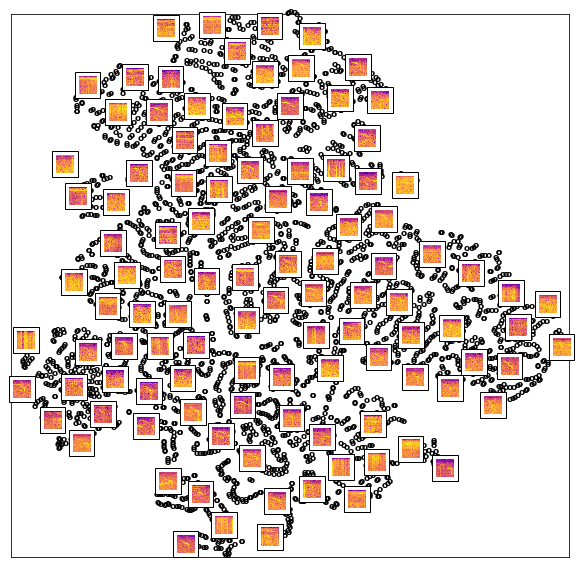

In [74]:
plot_embedding(np.array(X).T, X_embedded)
plt.show()

### Supervised Prediction

In this competition we have the privilige to have annotated data. So let's use those labels. We are in fact trying to solve a classification problem: we want to build a classifier which correctly identifies whale calls.

`scikit learn` has many built-in classification algorithms. Random Forests is a general purpose nonlinear classification method, which usually works pretty well.

We will split the dataset in two parts: a training set and a testing set.

In [75]:
from sklearn.model_selection import train_test_split

In [76]:
target_names = ['Upcall', 'NO_Upcall']

In [77]:
y = np.array(labels['label'][X.columns])
         
X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.20, random_state=2018)

print(X_train.shape)

(24000, 3540)


In [78]:
from sklearn.ensemble import RandomForestClassifier

/Users/valentina/anaconda/envs/data_mining_test/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/valentina/anaconda/envs/data_mining_test/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [79]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Evaluation

Ok, we fitted a classifier, but how should we evaluate performance? First let's look at the accuracy on the train dataset: it better be good!!!

In [80]:
# prediction on the training dataset
train_accuracy = 1 - np.sum(np.abs(clf.predict(X_train) - y_train))/len(y_train)
print('Accuracy on the train dataset is '+ str(train_accuracy))

Accuracy on the train dataset is 0.9341666666666667


But what we want to know is how the method performs on the test dataset, whose labels we have not seen in training.

In [81]:
# prediction on the testing dataset
test_accuracy = 1 - np.sum(np.abs(clf.predict(X_test)-y_test))/len(y_test)
print('Accuracy on the test dataset is '+ str(test_accuracy))

Accuracy on the test dataset is 0.844


Ok, it is lower, as expected, but still decent.

Question: what will be the accuracy if we always claim there is no whale call?

Hint: what is the percentage of snippets with whale calls?

In [82]:
1 - y_test.sum()/len(y_test)

0.7695

Other measures: [Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) - Area Under the Curve (ROC AUC)

The ROC curve allows explore how the algorithm performs for different decison thresholds.

In [83]:
from sklearn.metrics import roc_auc_score, roc_curve
y_score = clf.predict_proba(X_test)[:,1]
print(y_score)
roc_auc = roc_auc_score(y_test, y_score)
fpr, tpr, _ = roc_curve(y_test, y_score)


[0.33406848 0.25336438 0.00721702 ... 0.00330567 0.30727013 0.00922169]


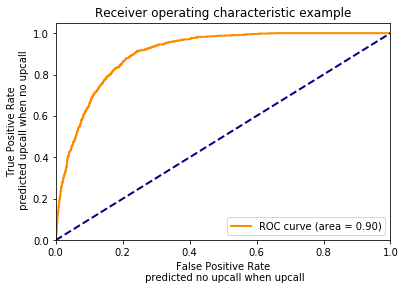

In [84]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate\n predicted no upcall when upcall')
plt.ylabel('True Positive Rate\n predicted upcall when no upcall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Are the low dimensional feautures better??? Which ones?

Let's use the low dimensional features.

In [85]:
y = np.array(labels['label'][X.columns])
         
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=2018)

print(X_train.shape)

(24000, 30)


In [86]:
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [87]:
train_accuracy = 1 - np.sum(np.abs(clf.predict(X_train) - y_train))/len(y_train)
print('Accuracy on the train dataset is '+ str(train_accuracy))

Accuracy on the train dataset is 0.9197916666666667


In [88]:
test_accuracy = 1 - np.sum(np.abs(clf.predict(X_test) - y_test))/len(y_test)
print('Accuracy on the test dataset is '+ str(test_accuracy))

Accuracy on the test dataset is 0.8701666666666666


In [89]:
true = y_test==1

precision = sum(clf.predict(X_test)[true])/sum(true)
print(precision)

0.64352856109906


In [96]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_pred, y_test)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.53


Text(0.5,1,'2-class Precision-Recall curve: AP=0.53')

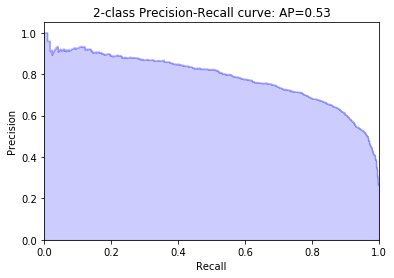

In [97]:
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:,1]
                     
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [99]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_pred, y_test)

array([[4331,  493],
       [ 286,  890]])

Normalized confusion matrix
[[0.94 0.06]
 [0.36 0.64]]


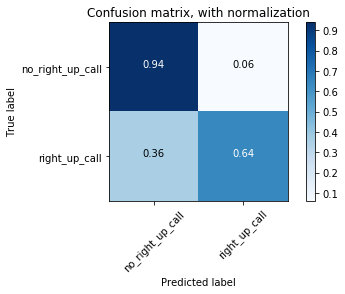

In [100]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['no_right_up_call','right_up_call']
plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix, with normalization')

[F1 score](https://en.wikipedia.org/wiki/F1_score)

In [101]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.6955842125830403

How can we improve:


* perform cross validation

* account for time shifting

* equalize spectrograms

* try other classifiers: gradient boosting, SVM

* ???


### References:
* https://github.com/jaimeps/whale-sound-classification

* https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf